In [1]:
#set random seeds
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)

import pandas as pd
import numpy as np

#machine learning
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers 
from tensorflow import keras
from sklearn.model_selection import train_test_split

#accessing files
from google.cloud import storage
import os

#display charts/images
import matplotlib.pyplot as plt

#don't need
# from tensorflow.python.keras.preprocessing import sequence
# from tensorflow.python.keras.preprocessing import text
# import tensorflow_hub as hub




2.3.0


In [2]:
params = {
    'image_size': [225, 225],
    'text_input': (58,),
    'batch_size': 512,
    'vocab_size': 30000,
    'examples_per_file': 850, #will not change
    'test_examples_per_file': 500,
    'version': 7 #model version number
}

In [3]:
try:
    from google.colab import auth
    auth.authenticate_user()
    credentials=None

except ModuleNotFoundError:


    from google.oauth2 import service_account

    credentials = service_account.Credentials.from_service_account_file( #file location of GCS private key
        '/Users/jeremiahherberg/Downloads/hateful-memes-af65c70c1b79.json')

client = storage.Client(project='hateful-memes', credentials=credentials)

In [4]:
num_examples_per_tfrecordfile = params['examples_per_file'] # 850 #this will not change

In [5]:
bucket = 'jh_hateful_memes'
client = storage.Client(project='hateful-memes', credentials=credentials)
objects = client.list_blobs(bucket, prefix='hatefulmemes_')
tfrecords = []
for object_ in objects:
    path = str(object_).split(', ')[1]
    gs_path = os.path.join('gs://', bucket, path)
    tfrecords.append(gs_path) #gs_path

In [6]:
# tfrecords

In [7]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.37.177.186:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.37.177.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.37.177.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [8]:
def decode_example_train(example):
    '''
    decodes single tfexample from TFrecord file
    '''
    features = {'label': tf.io.FixedLenFeature([], tf.int64),
                'text': tf.io.FixedLenFeature([], tf.string),
                'text_lemma': tf.io.FixedLenFeature([], tf.string),
                'text_lemma_no_stopwords': tf.io.FixedLenFeature([], tf.string),
                'text_no_stopwords':tf.io.FixedLenFeature([], tf.string),
                'image': tf.io.FixedLenFeature([], tf.string)}
    single_example = tf.io.parse_single_example(example, features)
    
    text = tf.io.parse_tensor(single_example['text'], out_type=tf.int32)
    textL = tf.io.parse_tensor(single_example['text_lemma'], out_type=tf.int32)
    # text = tf.cast(text, tf.float32) 
    image = tf.io.decode_jpeg(single_example['image'], 3)
    image = tf.image.resize_with_pad(image, *params['image_size'])
    image = image / 255.0
    label = single_example['label']
    # label = tf.cast(label, tf.float32)
    return text, textL, image, label

def decode_example_test(example):
    '''
    decodes single tfexample from TFrecord file
    '''
    features = {'id': tf.io.FixedLenFeature([], tf.int64),
                'text': tf.io.FixedLenFeature([], tf.string),
                'text_lemma': tf.io.FixedLenFeature([], tf.string),
                'text_lemma_no_stopwords': tf.io.FixedLenFeature([], tf.string),
                'text_no_stopwords':tf.io.FixedLenFeature([], tf.string),
                'image': tf.io.FixedLenFeature([], tf.string)}
    single_example = tf.io.parse_single_example(example, features)
    
    text = tf.io.parse_tensor(single_example['text'], out_type=tf.int32)
    textL = tf.io.parse_tensor(single_example['text_lemma'], out_type=tf.int32)
    # text = tf.cast(text, tf.float32) 
    image = tf.io.decode_jpeg(single_example['image'], 3)
    image = tf.image.resize_with_pad(image, *params['image_size'])
    image = image / 255.0
    label = single_example['id']
    # label = tf.cast(label, tf.float32)
    return text, textL, image, label

def flip_image(text, textL, image, label): 
    '''
    randombly flips image input
    
    args:
        text: text output in ds
        image: image output in ds
        label: label output in ds (can also be id)
    returns:
        text, image, label
        args will be otherwise unchanged
    '''
    
    image = tf.image.random_flip_left_right(image)

    return text, textL, image, label


def convert_xy(text, textL, image, label): #needs to be called last
    '''
    transforms ds output from text, image, label -> (text, image), label
    
    args:
        text: text output in ds
        image: image output in ds
        label: label output in ds (can also be id)
    returns:
        (text, image), label
        args will be otherwise unchanged
    '''
    return (text, textL, image), label
    
    

In [9]:
def create_ds(files, params, train=True, test_examples=1000):
    '''
    function to create dataset for training/validation
    
    args:
        files: list of str, filepaths of TFrecord files to be used in DS
        params: dict with the following keys:
            batch_size: int, batch size of training/validation step
            examples_per_file: int, number of examples in each TFrecord file
        train, bool, default True, indicator if the DS is for training
        test_examples, int: default 1000 number of examples in test dataset
    returns:
        ds: tensorflow input pipeline with images, text and labels
            output of ds is: (text, image), label
        ds_batches: int, number of steps in each epoch based on the batch_size
    '''
    file_size = params['examples_per_file'] 
    batch_size = file_size * len(files)

    ds = tf.data.TFRecordDataset(filenames = files)
    if train:
        ds = ds.map(decode_example_train, 
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.map(flip_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    else:
        ds = ds.map(decode_example_test)
    ds = ds.map(convert_xy, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if train:
        ds = ds.batch(batch_size, drop_remainder=True)
    else:
        ds = ds.batch(test_examples)
    ds = ds.cache() 
    
    ds_batches = 10 #(len(files) * file_size) // batch_size
    return ds, ds_batches
    
    

In [10]:
def pair_separableConv1D(x, 
                         filters, kernal_size, act, first_reg, sec_reg,
                        maxpooling_poolsize):
    '''
    function to add the following layers to a Keras Functional model:
        layers.SeparableConv1D
        layers.SeparableConv1D
        layers.MaxPooling1D
    
    args:
        x: keras input layer, or series of layers that can be traced to input layer
        kernal_size: int, kernal size for SeparableConv1D layers
        act: str, activation for SeparableConv1D layers
        first_reg, keras regularizer to pass into 1st conv layer
        sec_reg, keras regularizer to pass into 2nd conv layer
        maxpooling_poolsize: int, poolsize for maxpooling layer
    
    returns:
        x: x that was input into fn with above layers added
    '''
    x = layers.SeparableConv1D(filters=filters, kernel_size=kernal_size, 
                              activation=act, padding='same',
                              kernel_regularizer=first_reg)(x)
    x = layers.SeparableConv1D(filters=filters, kernel_size=kernal_size, 
                              activation=act, padding='same',
                              kernel_regularizer=sec_reg)(x)
    x = layers.MaxPooling1D(pool_size=maxpooling_poolsize, padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

In [11]:
def conv2dset(x, 
              conv_filter, kernel, regularizer=None, 
              maxpooling_poolsize=2, 
              conv_act=None, 
              dense_units=None, dense_act=None):
    '''
    function to add the following layers to a Keras Functional model:
        layers.Conv2D
        MaxPooling2D
        Batchnormalization
        (activation layer)
        layers.Dense (if applicable)
    
    args:
        x: keras input layer, or series of layers that can be traced to input layer
        conv_filter: int, number of filters in Conv2D layer
        kernel: int, kernel size in Conv2D layer
        regularizer: keras.regularizers object, default: None, regularizer in 
            Conv2D layer
        maxpooling_poolsize: int, default 2, poolsize for maxpooling layer
        conv_act: keras layer (without the "()"), default None, activation
            layer that will go after the batchnormalization layer
        dense_units: int, default None, number of units in dense layer
            if None, there will be no dense layer
        dense_act: str, default None, activation in dense layer
    
    returns:
        x: x that was input into fn with above layers added
        
    '''
    x = layers.Conv2D(filters=conv_filter, kernel_size=kernel, padding='same', 
                      kernel_regularizer=regularizer)(x)
    x = layers.MaxPooling2D(maxpooling_poolsize)(x)
    # x = layers.BatchNormalization()(x)
    if conv_act:
        x = conv_act()(x)
    if dense_units:
        x = layers.Dense(dense_units, activation=dense_act)(x)
    
    return x



In [12]:
def create_model(params=params,):
    '''
    creates model with two inputs and out output

        
    '''
    #set some fixed variables
    text_input_shape = params['text_input']
    vocab_size = params['vocab_size']
    image_size = params['image_size']
    dense_nodes = 300
    ltsm_units = 128
    ltsm_dense_units = 64
    relu = layers.ReLU
    reg = keras.regularizers.l2(0.001,)
    
    #model inputs
    input_text = layers.Input(text_input_shape, name='text_input')
    embedding = layers.Embedding(input_dim=vocab_size, output_dim=64, 
                                 input_length=58, mask_zero=True)(input_text)
    input_lemma = layers.Input(text_input_shape, name='test_lemma_input')
    lemma_embedding = layers.Embedding(input_dim=vocab_size, output_dim=64,
                                       input_length=58, mask_zero=True)(input_lemma)
    input_image = layers.Input((*image_size, 3), name='image_input')


    #bidirectional LSTM - original text
    x_bidir = embedding
    x_bidir = layers.Bidirectional(layers.LSTM(ltsm_units))(x_bidir)
    x_bidir = layers.Dense(ltsm_dense_units, activation = 'relu')(x_bidir)
    x_bidir_out = layers.Dense(dense_nodes, activation='sigmoid', name='bidirectional_out')(x_bidir)

    #1D convolution - original text
    x_text = embedding
    x_text = pair_separableConv1D(x_text, 128, 4, 'relu', reg, None, 4)
    x_text = pair_separableConv1D(x_text, 128, 4, 'relu', None, None, 4)
    x_text = layers.Flatten()(x_text)
    x_text = layers.Dense(dense_nodes, activation='tanh',kernel_regularizer=reg)(x_text)
    output_layer_text = layers.Dense(dense_nodes, activation='sigmoid', name='text_output')(x_text)


    #1D convolution - lemma
    x_lemma = lemma_embedding
    x_lemma = pair_separableConv1D(x_lemma, 128, 4, 'relu', reg, None, 4)
    x_lemma = pair_separableConv1D(x_lemma, 128, 4, 'relu', None, None, 4)
    x_lemma = layers.Flatten()(x_lemma)
    # x_lemma = layers.Dense(dense_nodes, activation='tanh',kernel_regularizer=reg)(x_lemma)
    output_layer_lemma = layers.Dense(dense_nodes, activation='sigmoid', name='text_output_lemma')(x_lemma)

    #bidirectional LSTM - lemma
    x_bidirL = lemma_embedding
    x_bidirL = layers.Bidirectional(layers.LSTM(ltsm_units))(x_bidirL)
    x_bidirL = layers.Dense(ltsm_dense_units, activation = 'relu')(x_bidirL)
    x_bidir_outL = layers.Dense(dense_nodes, activation='sigmoid', name='bidirectional_out_lemma')(x_bidirL)


    #images
    x_img = input_image
    x_img = conv2dset(x_img, 64, 5, reg, 2, relu, 16, 'tanh')
    x_img = conv2dset(x_img, 128, 5, reg, 2,  relu, 1, 'tanh') #16, 'tanh'
    x_img = layers.Flatten()(x_img)
    # x_img = layers.Dense(dense_nodes, activation='tanh', kernel_regularizer=reg)(x_img) 
    output_layer_image = layers.Dense(dense_nodes, activation='softmax', name='image_out')(x_img)
    
    text_outputs = layers.Concatenate()([x_bidir_out, output_layer_text, output_layer_lemma, x_bidir_outL])
    text_outputs = layers.Dense(dense_nodes)(text_outputs)
    
    #only one output for images
    image_outputs = output_layer_image
    x = layers.Concatenate()([image_outputs, text_outputs])
    
    # x = tf.stack([ image_outputs,text_outputs])
    x = layers.Reshape(( 2, dense_nodes))(x)
    x = layers.LSTM(64)(x)
    # x = layers.Dense(dense_nodes)(x)
    x = layers.Flatten()(x)
    #consider adding an intrum dense layer here
    final_output = layers.Dense(1, activation='sigmoid', name='final_out')(x)
    
    model = keras.Model([input_text, input_lemma, input_image], final_output)
    metrics = [
          keras.metrics.TruePositives(name='tp'),
    #           keras.metrics.FalsePositives(name='fp'),
    #           keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
    #           keras.metrics.Precision(name='precision'),
    #           keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
    ]
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.0003, 10 *3, 0.75)
    model.compile(
    optimizer=tf.keras.optimizers.Adam(schedule),
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.01),
    metrics=metrics)
    
    return model
    


In [13]:
train_files, valid_files = train_test_split(tfrecords,
                              test_size=.2, random_state=1)


In [14]:
train_ds, train_steps = create_ds(train_files, params)
valid_ds, valid_steps = create_ds(valid_files, params)

In [15]:
tf.random.set_seed(1)
np.random.seed(1)
with strategy.scope():
    model = create_model()
    model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 58)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 58, 64)       1920000     text_input[0][0]                 
__________________________________________________________________________________________________
test_lemma_input (InputLayer)   [(None, 58)]         0                                            
__________________________________________________________________________________________________
separable_conv1d (SeparableConv (None, 58, 128)      8576        embedding[0][0]                  
_______________________________________________________________________________________

In [16]:
#calculate class weights
target_0 = 5450 #these values will not change (are from review of test ds)
target_1 = 3050
total = target_0 + target_1

class_weight_0 = (1 / target_0) * (total) / 2.0
class_weight_1 = (1 / target_1) * (total) / 2.0

class_weights = {0: class_weight_0, 1: class_weight_1}


#early stopping if validation auc stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', #val_auc
                                patience=50,
                                mode='max',
                                restore_best_weights=True)




for train_data, train_groundTruth in train_ds:
    for valid_data, valid_groundTruth in valid_ds:
        history = model.fit(train_data, 
                            train_groundTruth, 
                            steps_per_epoch=10, 
                            validation_data=(valid_data, valid_groundTruth), 
                            validation_steps=2,
                            callbacks=[early_stopping],
                            class_weight=class_weights,
                            epochs=250)


Epoch 1/250
 2/10 [=====>........................] - ETA: 0s - loss: 1.1223 - tp: 225.0000 - fn: 231.0000 - accuracy: 0.4956 - auc: 0.4965  WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0065s vs `on_train_batch_end` time: 0.1970s). Check your callbacks.


10/10 [==============================] - ETA: 0s - loss: 1.0980 - tp: 1205.0000 - fn: 1267.0000 - accuracy: 0.4909 - auc: 0.4927WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/multi_device_iterator_ops.py:601: get_next_as_optional (from tensorflow.python.data.ops.iterator_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


10/10 [==============================] - 14s 1s/step - loss: 1.0980 - tp: 1205.0000 - fn: 1267.0000 - accuracy: 0.4909 - auc: 0.4927 - val_loss: 1.0988 - val_tp: 578.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.3400 - val_auc: 0.5000
Epoch 2/250
10/10 [==============================] - 3s 263ms/step - loss: 1.0503 - tp: 754.0000 - fn: 1718.0000 - accuracy: 0.5582 - auc: 0.5029 - val_loss: 1.0268 - val_tp: 0.0000e+00 - val_fn: 578.0000 - val_accuracy: 0.6600 - val_auc: 0.5000
Epoch 3/250
10/10 [==============================] - 3s 296ms/step - loss: 1.0165 - tp: 2222.0000 - fn: 250.0000 - accuracy: 0.3900 - auc: 0.5009 - val_loss: 1.0026 - val_tp: 578.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.3400 - val_auc: 0.5000
Epoch 4/250
10/10 [==============================] - 3s 265ms/step - loss: 0.9892 - tp: 231.0000 - fn: 2241.0000 - accuracy: 0.6044 - auc: 0.5009 - val_loss: 0.9773 - val_tp: 578.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.3400 - val_auc: 0.5000
Epoch 5/250
10/10 [==========

In [17]:
def plot_metric(metric1, metric2, ylabel):
    plt.plot(history.history[metric1], label=metric1)
    plt.plot(history.history[metric2], label=metric2)
    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

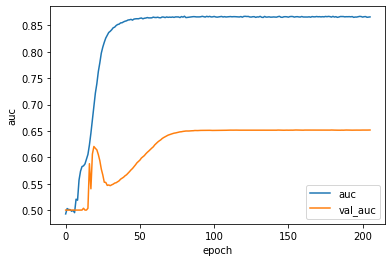

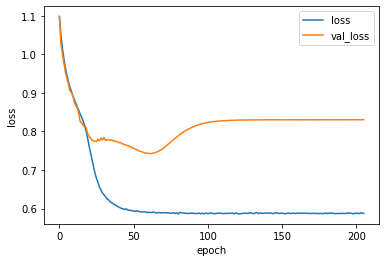

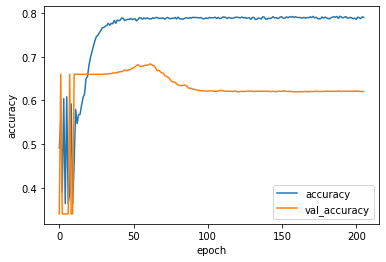

In [18]:
plot_metric('auc', 'val_auc', 'auc')
plot_metric('loss', 'val_loss', 'loss')
plot_metric('accuracy', 'val_accuracy', 'accuracy')

In [19]:
max(history.history['val_auc']) #300 - 0.6647 #250 - 0.6612 #200 - 0.569 #350 - 0.638

0.6518272757530212

In [20]:
model_name = 'model_hateful_memes_v{}.h5'.format(params['version'])
model.save(model_name)
bucket = client.bucket('jh_hateful_memes')
blob = bucket.blob(model_name)
blob.upload_from_filename(model_name)#fix this

In [21]:
#make into a fn
bucket = 'jh_hateful_memes_test'
client = storage.Client(project='hateful-memes', credentials=credentials)
objects = client.list_blobs(bucket, prefix='hatefulmemes_')
tfrecords = []
for object_ in objects:
    path = str(object_).split(', ')[1]
    gs_path = os.path.join('gs://', bucket, path)
    tfrecords.append(gs_path) #gs_path

In [22]:
test_ds, test_steps = create_ds(tfrecords, params, train=False)

In [23]:
for x_test, ids in test_ds:
    predictions = model.predict(x_test, steps=test_steps)
    prediction_ids = ids

In [24]:
prediction_dict = {
    'id': prediction_ids,
    'proba': np.concatenate(predictions),
    'label': np.ones(1000, int)
}
submission_ds = pd.DataFrame(prediction_dict)



In [25]:
submission_ds.to_csv('submission.csv', index=False)